# Interatomic Length Distribution

Our work is motivated by differences between geometric distribution of conformation generation methods.

In [1]:
import pickle
import torch
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
from data.data import dict_to_graph, rdkmol_to_graph, dft_mmff_to_graph
from rdkit import Chem
from rdkit.Chem import AllChem
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex']
%matplotlib inline

In [3]:
'''Load QM9 data'''
cutoff = 100
num_workers = 8

with open('data/QM9/qm9_all.pkl', 'rb') as f:
    qm9 = pickle.load(f)

qm9_split = np.array_split(qm9, num_workers)

def gsl(split):  # prepare qm9 graph, smiles, label
    graph = []
    smile = []
    label = []
    for d in split:
        graph.append(dict_to_graph(d, cutoff))
        smile.append(d['SMILES'])
        label.append(d['mu'])
    return graph, smile, label
cat_list = Parallel(n_jobs=num_workers)(delayed(gsl)(split) for split in qm9_split)

graphs = []
smiles = []
labels = []

for graph, smile, label in cat_list:
    graphs += graph
    smiles += smile
    labels += label

In [ ]:
'''try ETKDGv3 and list successful items with index'''
def etkdg_test(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    status = AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
    return mol, status

qm9_suc_idx = []
qm9_suc_mol = []
for i, data in tqdm(enumerate(qm9)):
    mol, stat_data = etkdg_test(data['SMILES'])  # 1 means fail
    if stat_data == 0:  # success
        qm9_suc_idx.append(i)
        qm9_suc_mol.append(mol)

'''optimize successful molecules via MMFF'''
def mmff(mol):
    AllChem.MMFFOptimizeMolecule(mol, confId=0)
    return mol

qm9_suc_mmff_mol = []
for mol in tqdm(qm9_suc_mol):
    qm9_suc_mmff_mol.append(mmff(mol))


In [ ]:

# open qm9_cgcf.pkl
with open('./data/QM9/qm9_all_cgcf.pkl', 'rb') as f:
    qm9_cgcf = pickle.load(f)
# Optimize using MMFF
qm9_cgcf_ff = []

for mol in tqdm(qm9_cgcf, desc='MMFF Optimize'):
    opt_mol = deepcopy(mol)
    AllChem.MMFFOptimizeMolecule(opt_mol)
    qm9_cgcf_ff.append(opt_mol)


graphs_list = []
smiles_list = []
qm9_etkdg_list = []  # filtered by successful index
qm9_etkdg_mmff_list = []  # filtered by successful index
qm9_cgcf_list = []  # not filtered by successful index
qm9_cgcf_ff_list = []  # not filtered by successful index

for i, mol, mol_mmff in tqdm(list(zip(qm9_suc_idx, qm9_suc_mol, qm9_suc_mmff_mol))):
    g = graphs[i]
    graphs_list.append(g)
    smiles_list.append(smiles[i])
    qm9_etkdg_list.append(rdkmol_to_graph(mol, g, cutoff))
    qm9_etkdg_mmff_list.append(rdkmol_to_graph(mol_mmff, g, cutoff))
    qm9_cgcf_list.append(rdkmol_to_graph(qm9_cgcf[i], g, cutoff))
    qm9_cgcf_ff_list.append(rdkmol_to_graph(qm9_cgcf_ff[i], g, cutoff))  # idx filtered already

In [6]:
'''Split dgl graph data'''
graphs_split = np.array_split(graphs_list, num_workers)
smiles_split = np.array_split(smiles_list, num_workers)  # string type data
qm9_cgcf_split = np.array_split(qm9_cgcf_list, num_workers)
qm9_cgcf_ff_split = np.array_split(qm9_cgcf_ff_list, num_workers)
qm9_etkdg_split = np.array_split(qm9_etkdg_list, num_workers)
qm9_etkdg_mmff_split = np.array_split(qm9_etkdg_mmff_list, num_workers)

In [7]:
'''Distance distribution of original dft data'''
def cat_graph_dist(split):
    cat = np.array([])
    for d in split:
        cat = np.hstack([cat, torch.norm(d.edata['r'], dim=-1).numpy()])
    return cat
dft_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(split) for split in graphs_split)
dft_cat = np.array([])
for l in dft_cat_list:
    dft_cat = np.hstack([dft_cat, l])
len(dft_cat)

38403006

In [8]:
'''Distance distribution of cgcf generated data'''
def cat_graph_dist(split):
    cat = np.array([])
    for d in split:
        cat = np.hstack([cat, torch.norm(d.edata['r'], dim=-1).numpy()])
    return cat
cgcf_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(split) for split in qm9_cgcf_split)
cgcf_cat = np.array([])
for l in cgcf_cat_list:
    cgcf_cat = np.hstack([cgcf_cat, l])
len(cgcf_cat)

38403006

In [9]:
'''Distance distribution of cgcf MMFF data'''
def cat_graph_dist(split):
    cat = np.array([])
    for d in split:
        cat = np.hstack([cat, torch.norm(d.edata['r'], dim=-1).numpy()])
    return cat
cgcf_ff_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(split) for split in qm9_cgcf_ff_split)
cgcf_ff_cat = np.array([])
for l in cgcf_ff_cat_list:
    cgcf_ff_cat = np.hstack([cgcf_ff_cat, l])
len(cgcf_ff_cat)

38403006

In [10]:
'''Distance distribution of ETKDG data'''
def cat_graph_dist(split):
    cat = np.array([])
    for d in split:
        cat = np.hstack([cat, torch.norm(d.edata['r'], dim=-1).numpy()])
    return cat
etkdg_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(split) for split in qm9_etkdg_split)
etkdg_cat = np.array([])
for l in etkdg_cat_list:
    etkdg_cat = np.hstack([etkdg_cat, l])
len(etkdg_cat)

38403006

In [11]:
'''Distance distribution of ETKDG MMFF data'''
def cat_graph_dist(split):
    cat = np.array([])
    for d in split:
        cat = np.hstack([cat, torch.norm(d.edata['r'], dim=-1).numpy()])
    return cat
etkdg_mmff_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(split) for split in qm9_etkdg_mmff_split)
etkdg_mmff_cat = np.array([])
for l in etkdg_mmff_cat_list:
    etkdg_mmff_cat = np.hstack([etkdg_mmff_cat, l])
len(etkdg_mmff_cat)

38403006

In [12]:
'''Distance distribution of MMFF-optimizd data from DFT initial conformation'''
def cat_graph_dist(i):
    cat = np.array([])
    for j, g in enumerate(graphs_split[i]):
        # print(j)
        s = dft_mmff_to_graph(smiles_split[i][j], g, cutoff)
        cat = np.hstack([cat, torch.norm(s.edata['r'], dim=-1).numpy()])
    return cat
dft_mmff_cat = np.array([])
# dft_mmff_cat_list = Parallel(n_jobs=num_workers)(delayed(cat_graph_dist)(i) for i in range(num_workers))
# for l in dft_mmff_cat_list:
#     dft_mmff_cat = np.hstack([dft_mmff_cat, l])
for i in range(num_workers):
    l = cat_graph_dist(i)
    dft_mmff_cat = np.hstack([dft_mmff_cat, l])
len(dft_mmff_cat)

38403006

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

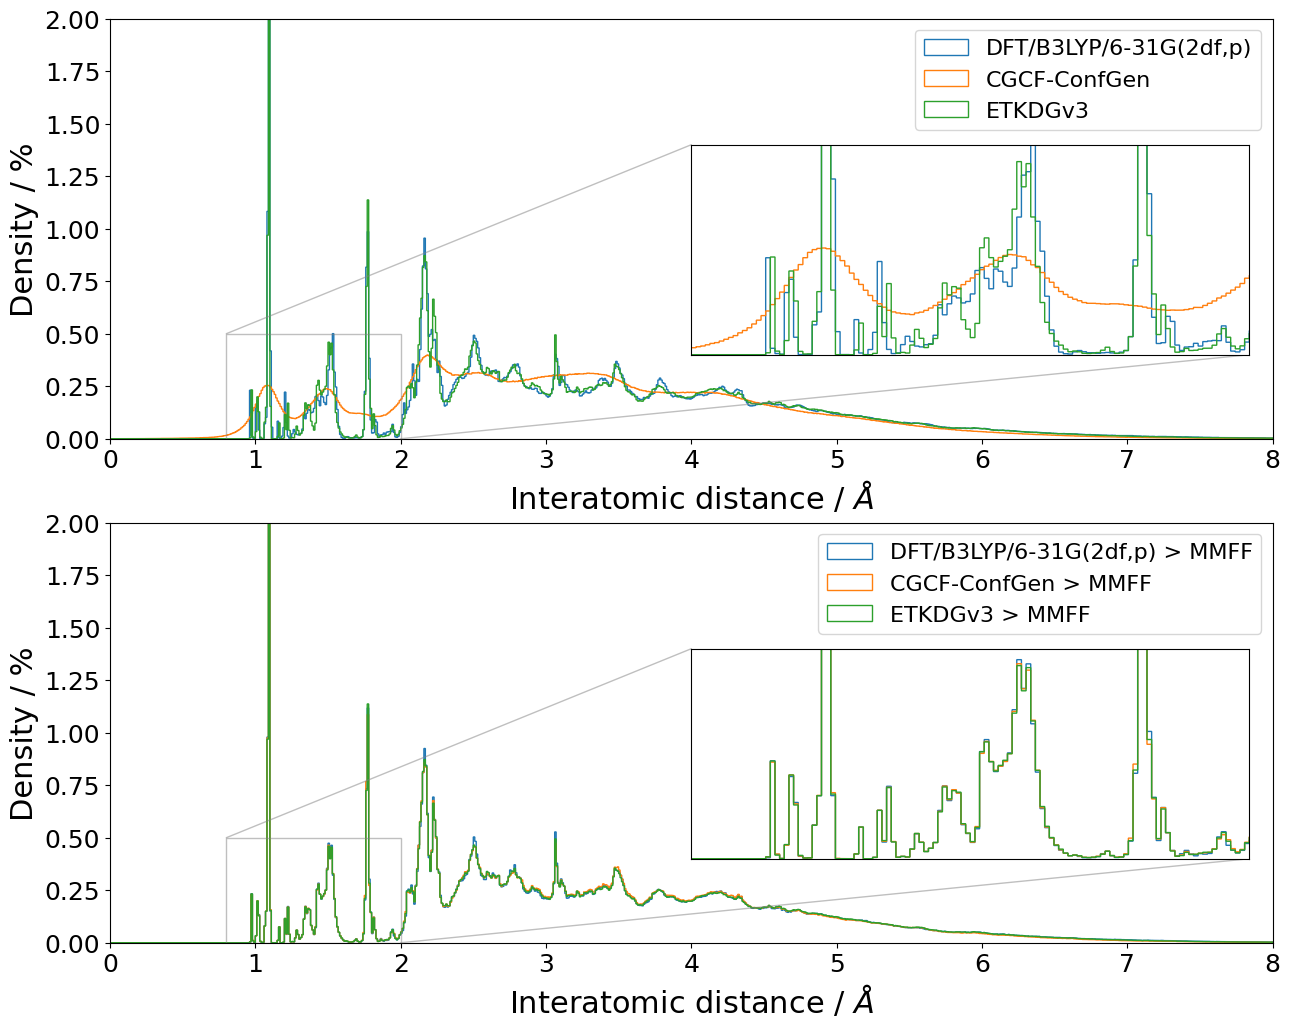

In [13]:
fontdict = {'fontname': 'Times New Roman', 'fontsize':22}

plt.figure(figsize=(15, 12))
ax1 = plt.subplot(2,1,1)
plt.hist(dft_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='DFT/B3LYP/6-31G(2df,p)')
plt.hist(cgcf_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='CGCF-ConfGen')
plt.hist(etkdg_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='ETKDGv3')
plt.xlim((0,8))
plt.ylim((0,2))
axins = ax1.inset_axes([0.5,0.2,0.48,0.5])
axins.hist(dft_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='DFT/B3LYP/6-31G(2df,p)')
axins.hist(cgcf_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='CGCF-ConfGen')
axins.hist(etkdg_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='ETKDGv3')
axins.set_xlim((0.8,2))
axins.set_ylim((0,0.5))
axins.set_xticks([])
axins.set_yticks([])
ax1.indicate_inset_zoom(axins)
plt.xlabel('Interatomic distance / '+r'$\AA$', fontdict=fontdict)
plt.ylabel('Density / %', fontdict=fontdict)
plt.xticks(fontname='Times New Roman', fontsize = 18)
plt.yticks(fontname='Times New Roman', fontsize = 18)
plt.legend(prop={'family':'Times New Roman', 'size': 16})

ax2 = plt.subplot(2,1,2)
plt.hist(dft_mmff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='DFT/B3LYP/6-31G(2df,p) > MMFF')
plt.hist(cgcf_ff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='CGCF-ConfGen > MMFF')
plt.hist(etkdg_mmff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='ETKDGv3 > MMFF')
plt.xlim((0,8))
plt.ylim((0,2))
axins = ax2.inset_axes([0.5,0.2,0.48,0.5])
axins.hist(dft_mmff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='DFT/B3LYP/6-31G(2df,p) > MMFF')
axins.hist(cgcf_ff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='CGCF-ConfGen > MMFF')
axins.hist(etkdg_mmff_cat, bins=np.arange(1000)/100, histtype='step', density=True, label='ETKDGv3 > MMFF')
axins.set_xlim((0.8,2))
axins.set_ylim((0,0.5))
axins.set_xticks([])
axins.set_yticks([])
ax2.indicate_inset_zoom(axins)
plt.xlabel('Interatomic distance / '+r'$\AA$', fontdict=fontdict)
plt.ylabel('Density / %', fontdict=fontdict)
plt.xticks(fontname='Times New Roman', fontsize = 18)
plt.yticks(fontname='Times New Roman', fontsize = 18)
plt.legend(prop={'family':'Times New Roman', 'size': 16})
plt.savefig('images/QM9_DFT_ETKDG_CGCF_dist.png', dpi=500, format='png', transparent=True)
plt.show()